# Computer Vision 101

### Wiener Filter

In [ ]:
%matplotlib inline
from skimage import color, data, restoration
import scipy.fftpack as fp
from skimage.measure import compare_psnr
from skimage.io import imread
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def convolve2d(im, psf, k):
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant') # assumption: min(M,N) > k > 0, k odd
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq*freq_kernel))

def plot_freq_filter(F, title, size=20):
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(F))), cmap='coolwarm'), plt.title(title, size=size), plt.colorbar()

def plot_freq_spec_3d(freq):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    Y = np.arange(-freq.shape[0]//2,freq.shape[0]-freq.shape[0]//2)
    X = np.arange(-freq.shape[1]//2,freq.shape[1]-freq.shape[1]//2)
    X, Y = np.meshgrid(X, Y)
    Z = (20*np.log10( 0.01 + fp.fftshift(freq))).real
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                           linewidth=0, antialiased=True)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.show()

im = color.rgb2gray(imread('images/earth_from_sky.png'))
k = 5
psf = np.ones((k, k)) / k**2
im1 = convolve2d(im, psf, k)
im1 += 0.3 * im.std() * np.random.standard_normal(im.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)
im3 = restoration.wiener(im1, psf, balance=0.25)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharex=True, sharey=True)
plt.gray()
axes[0,0].imshow(im), axes[0,0].axis('off'), axes[0,0].set_title('Original image', size=20)
axes[0,1].imshow(im1), axes[0,1].axis('off'), axes[0,1].set_title('Noisy blurred image: PSNR={:.3f}'.format(compare_psnr(im, im1)), size=20)
axes[1,0].imshow(im2), axes[1,0].axis('off'), axes[1,0].set_title('Self tuned Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im2)), size=20)
axes[1,1].imshow(im2), axes[1,1].axis('off'), axes[1,1].set_title('Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im3)), size=20)
fig.tight_layout()
plt.show()

![1](https://user-images.githubusercontent.com/62965911/224312471-bf3466f2-d0ed-412b-8da2-046f6a4ed285.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(im))

![2](https://user-images.githubusercontent.com/62965911/224312486-9226a68d-8c1a-40bf-90d5-14bd11ace89a.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(im1))

![3](https://user-images.githubusercontent.com/62965911/224312496-e0655535-6fdc-4aa4-a13d-738ec39dfed9.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(im2))

![4](https://user-images.githubusercontent.com/62965911/224312499-fe765ff8-16ee-42ad-a7c8-636e938360cc.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(im3))

![5](https://user-images.githubusercontent.com/62965911/224312503-bc8e081f-0a55-49e7-91a3-adccf221e2ad.png)

### Constrained Least Squares (CLS) Filter

In [ ]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import wiener, unsupervised_wiener
from skimage.measure import compare_psnr
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

def pseudo_inverse_filter(y, h, epsilon):
    '''
    Hinv(u,v) = 1/H(u,v)   if |H(u,v)| > epsilon
                0          otherwise
    '''
    Hf = fp.fft2(fp.ifftshift(h))
    M, N = Hf.shape
    Hf[(np.abs(Hf)<epsilon)] = 0
    indices = np.where((np.abs(Hf)>=epsilon))
    Hf[indices] = np.ones((M,N))[indices] / Hf[indices]
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf)

def cls_filter(y,h,c,lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + lambd*Cf*np.conj(Cf))
    #Hf = np.abs(Hf)**2 / (np.abs(Hf)**2 + lambd*np.abs(Cf)**2)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf) 

# Input and display the binary image
x = rgb2gray(imread('images/building.png'))
print(x.shape)
M, N = x.shape
print(np.max(x))

plt.figure(figsize=(15,30))

plt.subplot(431), plt.imshow(x, cmap='gray'), plt.axis('off'), plt.title('Original', size=15)

# Blur the image, corrupt the image using WGN and display it
# h is the blurring filter, and sigma is the noise std
h = np.ones((4,4))/16
h = np.pad(h, [(M//2-2, M//2-2), (N//2-2, N//2-2)], mode='constant')
sigma = 0.075
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

plt.subplot(432), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('Blur Kernel (FFT)', size=15), plt.colorbar()

Y = Hf*Xf
y = fp.ifft2(Y).real + sigma*np.random.normal(size=(M,N))

plt.subplot(433), plt.imshow(np.abs(y), cmap='gray'), plt.axis('off'), plt.title('Degraded (PSNR: {})'.format(np.round(compare_psnr(x, y),3)), size=15)

# restoration using inverse filtering
epsilon = 0.25
pix, F_pseudo = pseudo_inverse_filter(y, h, epsilon)
plt.subplot(434), plt.imshow(pix, cmap='gray'), plt.axis('off'), plt.title('Restored (Pseudo-Inverse)\nPSNR: {}'.format(np.round(compare_psnr(x, pix),3)), size=15)
plt.subplot(435), plot_freq_filter(F_pseudo, 'Pseudo-Inverse Kernel (FFT)', size=15)

# restoration using wiener filtering
wx = wiener(y, h, balance=0.25)
plt.subplot(436), plt.imshow(wx, cmap='gray'), plt.axis('off'), plt.title('Restored (Wiener)\nPSNR: {}'.format(np.round(compare_psnr(x, wx),3)), size=15)

# restoration using unsupervised wiener filtering
uwx, _ = unsupervised_wiener(y, h)
plt.subplot(437), plt.imshow(uwx, cmap='gray'), plt.axis('off'), plt.title('Restored (Unsup.Wiener)\nPSNR: {}'.format(np.round(compare_psnr(x, uwx),3)), size=15)

# restoration using cls filtering
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))
plt.subplot(438), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Cf))), cmap='coolwarm'), plt.title('CLS Constraint Kernel (FFT)', size=15), plt.colorbar()
lambd = 20
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(439), plt.imshow(clx, cmap='gray'), plt.axis('off'), plt.title(r'Restored (CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=13)
plt.subplot(4,3,10), plot_freq_filter(F_restored, r'CLS Kernel (FFT), $\lambda=${}'.format(lambd), size=15)
lambd = 2
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(4,3,11), plt.imshow(clx, cmap='gray'), plt.axis('off'), plt.title(r'Restored (CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=13)
plt.subplot(4,3,12), plot_freq_filter(F_restored, r'CLS Kernel (FFT), $\lambda=${}'.format(lambd), size=15)

plt.show()

![6](https://user-images.githubusercontent.com/62965911/224312507-2ed5bff4-acdf-4e7d-83b1-ccf3984a7285.png)

In [ ]:
#freq_kernel = np.conj(Hf) / (Hf*np.conj(Hf) + alpha*Cf*np.conj(Cf))      
plot_freq_spec_3d(F_restored)

![7](https://user-images.githubusercontent.com/62965911/224312516-1da35198-a5db-4911-8e3a-2511a4232804.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(x))

![8](https://user-images.githubusercontent.com/62965911/224312520-ae8c1169-6d5c-40aa-8aa1-893fe887d74c.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(y))

![9](https://user-images.githubusercontent.com/62965911/224312525-8cb8073c-7ca2-403e-98b0-f01bfb186479.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(clx))

![10](https://user-images.githubusercontent.com/62965911/224312530-53354945-0348-4d66-ba41-07d6dff565ab.png)

In [ ]:
plot_freq_spec_3d(fp.fft2(uwx))

![11](https://user-images.githubusercontent.com/62965911/224312533-755a8160-ba13-47a2-80ac-f3f0ac877272.png)

In [ ]:
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.io import imread
im = rgb2gray(imread('images/book.png')) # street
(M, N), k = im.shape, 81 # a 21 x 21 motion blurred kernel
kernel = np.zeros((k, k))
for i in range(k):
    kernel[i, i] = 1
kernel = kernel / k
#print(kernel)
print(im.shape, kernel.shape)
im_blur = convolve2d(im, kernel, k) #, mode='same')
im_blur = random_noise(im_blur, var=0.0025)

from skimage.restoration import wiener, unsupervised_wiener

def cls_filter(y,h,c,lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + lambd*Cf*np.conj(Cf))
    #Hf = np.abs(Hf)**2 / (np.abs(Hf)**2 + lambd*np.abs(Cf)**2)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf) 

x = im
y = im_blur
h = kernel

h = np.pad(h, [(M//2-k//2, M//2-k//2-1), (N//2-k//2, N//2-k//2-1)], mode='constant')

# restoration using wiener filtering
wx = wiener(y, h, balance=0.1)
# restoration using cls filtering
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))
lambd = 7.5
clx, F_restored = cls_filter(y, h, c, lambd)

plt.figure(figsize=(15,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.02,0.04)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(im_blur), plt.axis('off'), plt.title('Degraded Image (with Motion-blur + Noise)\nPSNR: {}'.format(np.round(compare_psnr(x, y),3)), size=20)
plt.subplot(223), plt.imshow(wx), plt.axis('off'), plt.title('Restored Image (with Wiener) PSNR: {}'.format(np.round(compare_psnr(x, wx),3)), size=20)
plt.subplot(224), plt.imshow(clx), plt.axis('off'), plt.title(r'Restored Image (with CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=20)
plt.show()

![12](https://user-images.githubusercontent.com/62965911/224312539-0ffc62ff-1a4e-4fa1-a7f3-250eec1fed70.png)

### Noisy Image Restoration with Markov Random Field

Completed 0 iterations out of 655360
Completed 100000 iterations out of 655360
Completed 200000 iterations out of 655360
Completed 300000 iterations out of 655360
Completed 400000 iterations out of 655360
Completed 500000 iterations out of 655360
Completed 600000 iterations out of 655360


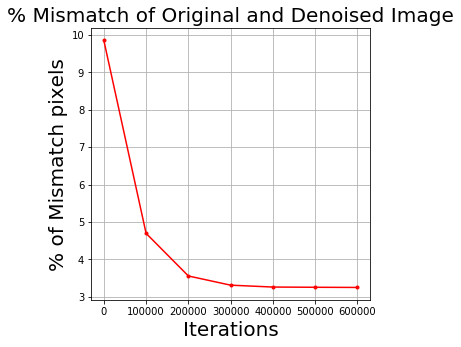

Percentage of mismatched pixels:  3.25164794921875


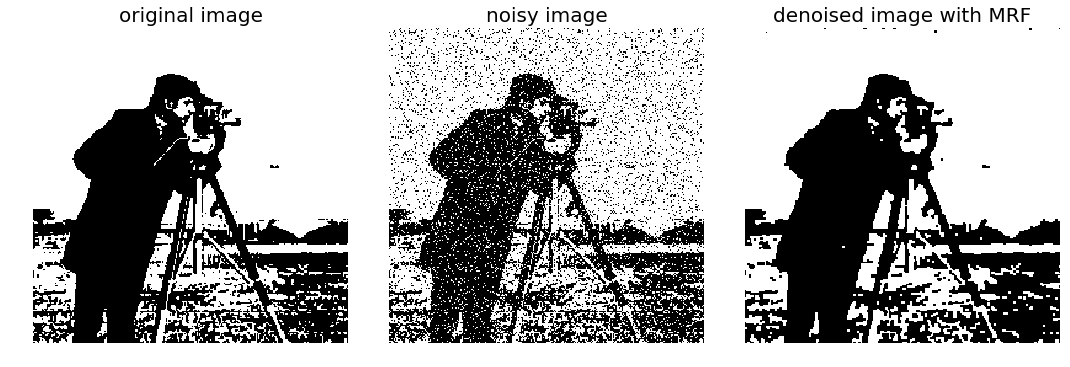

In [ ]:
% matplotlib inline
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pylab as plt

def plot_image(im, title):
  im = im.copy()
  im[im==-1] = 0
  im[im==1] = 255
  plt.imshow(im), plt.axis('off'), plt.title(title, size=20)

def plot_error(iters, errors):
    plt.figure(figsize=(5,5))
    plt.plot(iters, errors, 'r.-')
    plt.xlabel('Iterations', size=20)
    plt.ylabel('% of Mismatch pixels', size=20)
    plt.title('% Mismatch of Original and Denoised Image', size=20)
    plt.grid()
    plt.show()

def plot_images(orig_image, noisy_image, denoised_image):
    plt.figure(figsize=(15,5))
    plt.gray()
    plt.subplot(131), plot_image(orig_image, 'original image')
    plt.subplot(132), plot_image(noisy_image, 'noisy image')
    plt.subplot(133), plot_image(denoised_image, 'denoised image with MRF')
    plt.tight_layout()
    plt.show()
    
# preprocessing step
def read_image_and_binarize(image_file, threshold=128):
  im = (255*rgb2gray(plt.imread(image_file))).astype(int)
  im[im < threshold] = -1
  im[im >= threshold] = 1
  return im

def add_noise(im):
  im_noisy = im.copy()
  for i in range(im_noisy.shape[0]):
    for j in range(im_noisy.shape[1]):
      r = np.random.rand()
      if r < 0.1:
        im_noisy[i][j] = -im_noisy[i][j]
  return im_noisy

def compute_energy_helper(Y, i, j):
  try:
    return Y[i][j]
  except IndexError:
    return 0

def compute_energy(X, Y, i, j, zeta, eta, Y_i_j):
  energy = -eta * X[i][j] * Y_i_j #np.sum(X*Y) #
  for (k, l) in [(-1,0),(1,0),(0,-1),(0,1)]:
      energy -= zeta * Y_i_j * compute_energy_helper(Y, i+k, j+l)
  return energy

def denoise_image(O, X, zeta, eta):
  m, n = np.shape(X)
  Y = np.copy(X)
  max_iter = 10*m*n
  iters = []
  errors = []
  for iter in range(max_iter):
    # randomly pick a location
    i = np.random.randint(m)
    j = np.random.randint(n)
    # compute energies for Y_ij = +1 and -1
    energy_neg = compute_energy(X, Y, i, j, zeta, eta, -1)
    energy_pos = compute_energy(X, Y, i, j, zeta, eta, 1)
    # assign Y_ij to the value with min energy
    if energy_neg < energy_pos:
      Y[i][j] = -1
    else:
      Y[i][j] = 1
    if iter % 100000 == 0:
        print ('Completed', iter, 'iterations out of', max_iter)
        error = get_mismatched_percentage(O, Y)
        iters.append(iter)
        errors.append(error)
  plot_error(iters, errors)
  
  return Y

def get_mismatched_percentage(orig_image, denoised_image):
  diff = (orig_image != denoised_image)
  return (100.0 * np.sum(diff)) / np.size(orig_image)

orig_image = read_image_and_binarize('images/cameraman.png')
zeta = 1.5
eta = 2

# add noise
noisy_image = add_noise(orig_image)

# use ICM for denoising
denoised_image = denoise_image(orig_image, noisy_image, zeta, eta)

# print the percentage of mismatched pixels
print ('Percentage of mismatched pixels: ', get_mismatched_percentage(orig_image, denoised_image))

plot_images(orig_image, noisy_image, denoised_image)

### Image Inpainting with opencv-python

In [ ]:
import numpy as np
import cv2
import matplotlib.pylab as plt
im = cv2.imread('images/cat.png') #, cv2.CV_8U
mask = cv2.imread('images/cat_mask.png',0)
_, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
src = cv2.bitwise_and(im, im, mask= mask)
#print(mask.shape, im.shape)
mask = cv2.bitwise_not(mask)
dst1 = cv2.inpaint(src, mask, 5, cv2.INPAINT_NS)
dst2 = cv2.inpaint(src, mask, 5, cv2.INPAINT_TELEA)
plt.figure(figsize=(20,15))
plt.gray()
plt.subplot(231), plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original', size=20)
plt.subplot(232), plt.imshow(mask), plt.axis('off'), plt.title('Mask', size=20)
plt.subplot(233), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Tampered', size=20)
plt.subplot(234), plt.imshow(cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Inpainted (NS)', size=20)
plt.subplot(235), plt.imshow(cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Inpainted (TELEA)', size=20)
plt.show()

![13](https://user-images.githubusercontent.com/62965911/224312552-eabda6aa-1f46-4202-b1f6-4863644e1626.png)

### Image Inpainting with Convex Optimization

Solution found after 91 iterations:
    objective function f(sol) = 1.327656e+03
    stopping criterion: RTOL


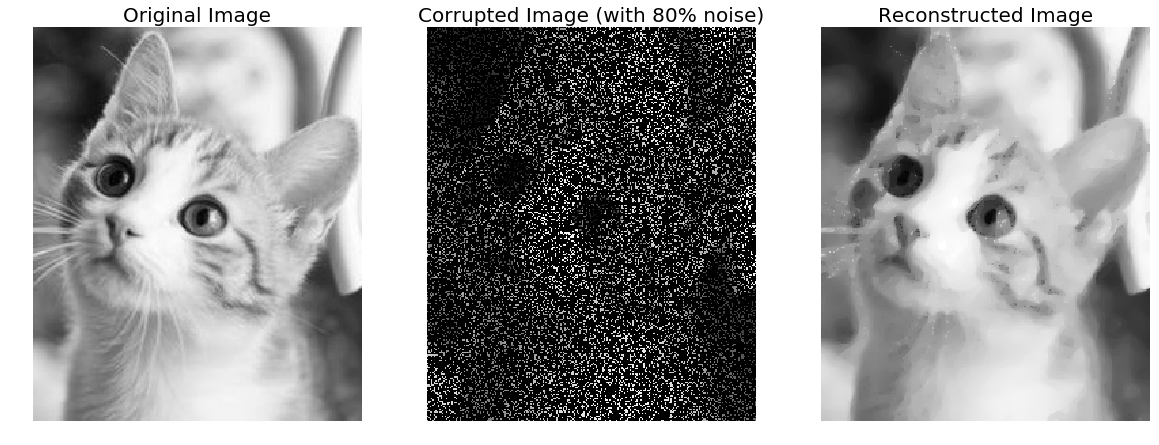

In [ ]:
#https://www.cvxpy.org/examples/applications/tv_inpainting.html
#https://pyunlocbox.readthedocs.io/en/stable/tutorials/reconstruction.html
from skimage.io import imread
from skimage.color import rgb2gray
from pyunlocbox import functions, solvers
import numpy as np
import matplotlib.pyplot as plt

im_original = rgb2gray(imread('images/cat.png'))
np.random.seed(1)  # Reproducible results.
mask = np.random.uniform(size=im_original.shape)
mask = mask > 0.8
g = lambda x: mask * x
im_corrupted = g(im_original)

f1 = functions.norm_tv(maxit=50, dim=2)
tau = 100
f2 = functions.norm_l2(y=im_corrupted, A=g, lambda_=tau) 
solver = solvers.forward_backward(step=0.5/tau)
x0 = np.array(im_corrupted)  # Make a copy to preserve im_corrupted.
ret = solvers.solve([f1, f2], x0, solver, maxit=100)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(im_original, cmap='gray')
ax[0].set_title("Original Image", size=20)
ax[0].axis('off')
ax[1].imshow(im_corrupted, cmap='gray')
ax[1].set_title("Corrupted Image (with 80% noise)", size=20)
ax[1].axis('off')
ax[2].imshow(ret['sol'], cmap='gray')
ax[2].set_title("Reconstructed Image", size=20)
ax[2].axis('off')
plt.show()

### Image Completion with Inpainting (using Deep learning - pre-trained torch CompletionNet model)

In [ ]:
# https://github.com/akmtn/pytorch-siggraph2017-inpainting

# must be run with pytorch version 0.4.1
# download the wheels from here: https://download.pytorch.org/whl/cpu/torch_stable.html
# pip install torch-0.4.1-cp37-cp37m-win_amd64.whl # --force-reinstall
# pip install "torchvision-0.4.1+cpu-cp37-cp37m-win_amd64.whl" # --force-reinstall
import os
import torch
from torch.legacy import nn
from torch.legacy.nn.Sequential import Sequential
import cv2
import numpy as np
from torch.utils.serialization import load_lua
import matplotlib.pylab as plt


def tensor2image(src):
    out = src.copy() * 255
    out = out.transpose((1, 2, 0)).astype(np.uint8)
    out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    return out

def image2tensor(src):
    out = src.copy()
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    out = out.transpose((2,0,1)).astype(np.float64) / 255
    return out

image_path = 'images/zebra.png'
mask_path = 'images/inpaint_mask.png'
# download model from http://hi.cs.waseda.ac.jp/~iizuka/data/completionnet_places2.t7
model_path = 'models/completionnet_places2.t7'
gpu = torch.cuda.is_available()

# load Completion Network
data = load_lua(model_path,long_size=8)
#data = torchfile.load(model_path, force_8bytes_long=True)
model = data.model
model.evaluate()

# load data
image = cv2.imread(image_path)
image = cv2.resize(image, (4*(image.shape[0]//4), 4*(image.shape[1]//4)))
I = torch.from_numpy(image2tensor(image)).float()

mask = cv2.imread(mask_path)
mask = cv2.resize(mask, (4*(mask.shape[0]//4), 4*(mask.shape[1]//4)))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) / 255
mask[mask <= 0.5] = 0.0
mask[mask > 0.5] = 1.0
#print(input.shape, mask.shape)
M = torch.from_numpy(mask).float()
M = M.view(1, M.size(0), M.size(1))
assert I.size(1) == M.size(1) and I.size(2) == M.size(2)

for i in range(3):
    I[i, :, :] = I[i, :, :] - data.mean[i]

# create mask_3ch
M3 = torch.cat((M, M, M), 0)

im = I * (M3*(-1)+1)

# set up input
input = torch.cat((im, M), 0)
input = input.view(1, input.size(0), input.size(1), input.size(2)).float()

if gpu:
    print('using GPU...')
    model.cuda()
    input = input.cuda()

# evaluate
res = model.forward(input)[0].cpu()

# make out
for i in range(3):
    I[i, :, :] = I[i, :, :] + data.mean[i]

out = res.float()*M3.float() + I.float()*(M3*(-1)+1).float()

image[mask > 0.5] = 255
plt.figure(figsize=(20,35))
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0, wspace=0.05, hspace=0.05)
plt.subplot(211), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Incomplete Image', size=20)
plt.subplot(212), plt.imshow(cv2.cvtColor(tensor2image(out.numpy()), cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Completed Image (with CompletionNet)', size=20)
#plt.savefig('inpainting_out.png', bbox_in='tight', pad_in=0)
plt.show()

print('Done')

![14](https://user-images.githubusercontent.com/62965911/224312561-f45c3c33-21f1-40c2-a045-9cc53dd1cf51.png)

### Steganography and Steganalysis

In [ ]:
#!pip install Stegano
import stegano
from PIL import Image, ImageChops
from stegano import lsb, lsbset
from stegano.steganalysis import statistics, parity
import matplotlib.pylab as plt
cover = Image.open('images/lena.png').convert('RGB')
stego = lsb.hide("images/lena.png", 10*"Python Image Processing Cookbook - LSB data hiding with Stegano").convert('RGB')
stego.save("images/lena-secret.png")
print(lsb.reveal("images/lena-secret.png"))
parity_encoded_cover = parity.steganalyse(cover)
parity_encoded_stego = parity.steganalyse(stego)
_, cover_common = statistics.steganalyse(cover)
_, stego_common = statistics.steganalyse(stego)

Python Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with Stegano


In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(231), plt.imshow(cover), plt.axis('off'), plt.title('Cover Image', size=20)
plt.subplot(232), plt.imshow(stego), plt.axis('off'), plt.title('Stego Image', size=20)
plt.subplot(233), plt.imshow(ImageChops.difference(stego, cover)), plt.axis('off'), plt.title('Diff Image', size=20)
plt.subplot(234), plt.imshow(parity_encoded_cover), plt.axis('off'), plt.title('Parity Encoded Cover Image', size=20)
plt.subplot(235), plt.imshow(parity_encoded_stego), plt.axis('off'), plt.title('Parity Encoded Stego Image', size=20)
plt.subplot(236), plt.imshow(ImageChops.difference(parity_encoded_stego, parity_encoded_cover)), plt.axis('off'), plt.title('Diff in Parity Encoded Images', size=20)
plt.show()

![15](https://user-images.githubusercontent.com/62965911/224312617-9c8658d3-1df7-4c20-a443-c607cbaa46a7.png)

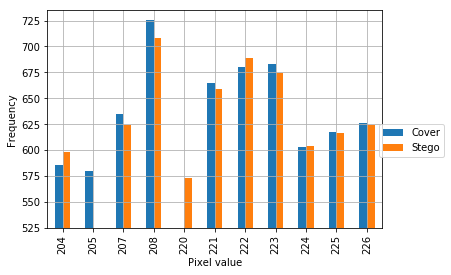

In [ ]:
import pandas as pd
def plot_freq(cover_common, stego_common):
    pixel_freq = list(zip(*cover_common))
    pixel = pixel_freq[0]
    freq = pixel_freq[1]
    df1 = pd.DataFrame({'Pixel':pixel, 'Freq':freq, 'Group':'Cover'})
    pixel_freq = list(zip(*stego_common))
    pixel = pixel_freq[0]
    freq = pixel_freq[1]
    df2 = pd.DataFrame({'Pixel':pixel, 'Freq':freq, 'Group':'Stego'})
    df = pd.concat([df1, df2])
    df.pivot("Pixel", "Group", "Freq").plot(kind='bar').legend(bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.ylim((525, 735))
    plt.grid()
    plt.show()

plot_freq(cover_common, stego_common)

In [ ]:
cover_common

[(208, 726),
 (223, 683),
 (222, 680),
 (221, 665),
 (207, 635),
 (226, 626),
 (225, 617),
 (224, 603),
 (204, 586),
 (205, 580)]

In [ ]:
stego_common

[(208, 708),
 (222, 689),
 (223, 674),
 (221, 659),
 (207, 624),
 (226, 624),
 (225, 616),
 (224, 604),
 (204, 598),
 (220, 573)]

(220, 220) (220, 220)


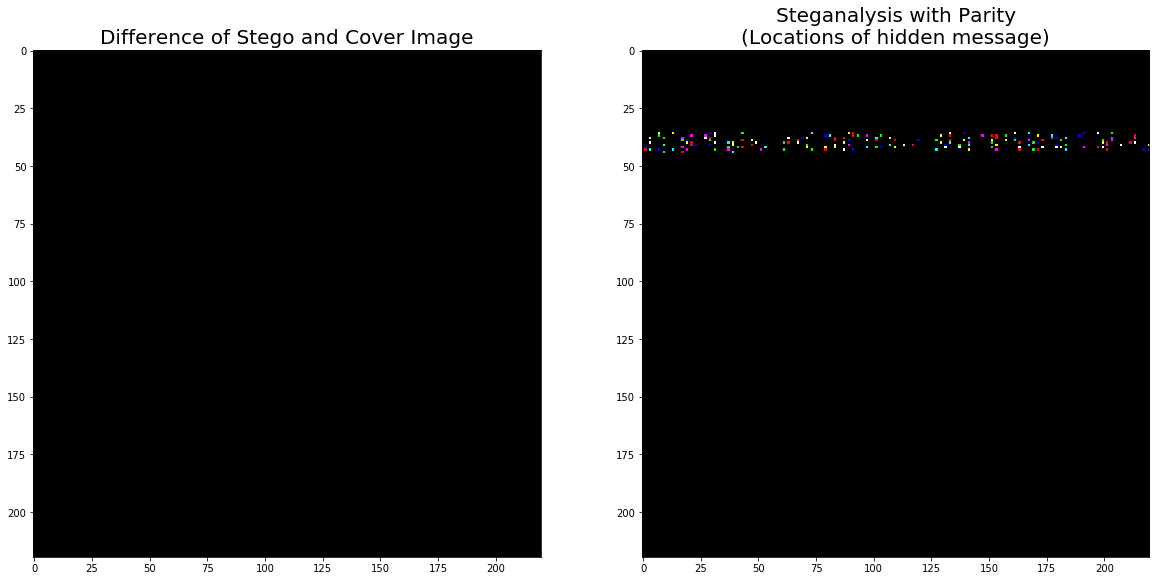

Could not decode with the generator provided!


'Python Image Processing Cookbook - LSB data hiding with Stegano lsbset!'

In [ ]:
from stegano import lsbset
from stegano.lsbset import generators

cover = Image.open("images/lena.png").convert('RGB')
# Hide a secret with the Sieve of Eratosthenes
secret_message = "Python Image Processing Cookbook - LSB data hiding with Stegano lsbset!"
n = 1000
stego = lsbset.hide("images/lena.png",
                                secret_message,
                                generators.eratosthenes(),
                                shift = n).convert('RGB')
stego.save("images/stego.png")
print(stego.size, cover.size)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(ImageChops.difference(stego, cover), cmap='hot')
plt.title('Difference of Stego and Cover Image', size=20)
plt.subplot(122)
plt.imshow(ImageChops.difference(parity.steganalyse(stego), parity.steganalyse(cover)), cmap='hot')
plt.title('Steganalysis with Parity\n(Locations of hidden message)', size=20)
plt.show()

try:
    # Try to decode with another generator
    message = lsbset.reveal("images/stego.png", generators.fibonacci(), shift = n)
except:
    print('Could not decode with the generator provided!')
    
message = lsbset.reveal("images/stego.png", generators.eratosthenes(), shift = n)
message

In [ ]:
from stegano import exifHeader
secret = exifHeader.hide("images/butterfly.jpg", "images/stego.png", secret_message=5*"Python Image Processing Cookbook - LSB data hiding with Stegano")
print(exifHeader.reveal("images/stego.png"))

b'Python Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with SteganoPython Image Processing Cookbook - LSB data hiding with Stegano'


### Image Restoration with Dictionary Learning

Distorting image...
Extracting reference patches...
done in 0.02s.
Learning the dictionary...
done in 25.69s.


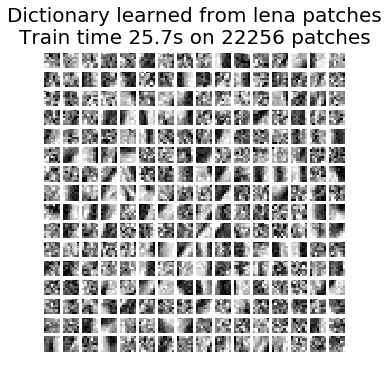

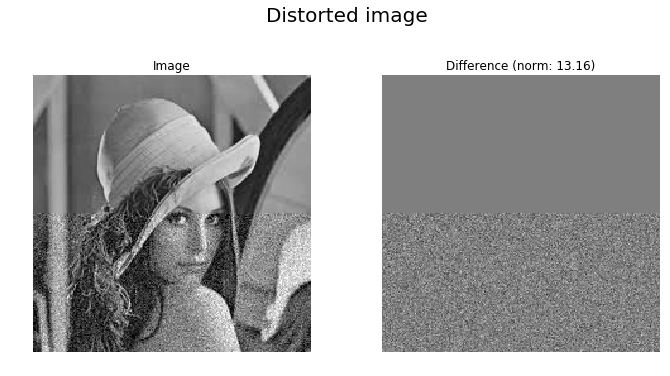

Extracting noisy patches... 
done in 0.01s.
Orthogonal Matching Pursuit
2 atoms...
done in 4.87s.


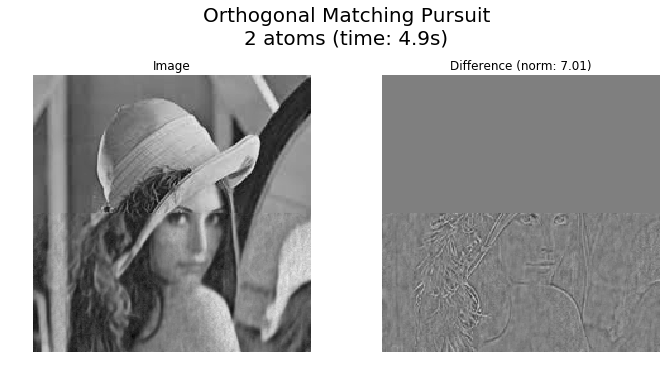

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import numpy as np
import matplotlib.pylab as plt
from time import time

lena = rgb2gray(imread('images/lena.png'))
#print(lena.shape, lena.dtype, np.max(lena))
height, width = lena.shape

# Distort the lower half of the image
print('Distorting image...')
distorted = lena.copy()
distorted[height // 2:, :] += 0.085 * np.random.randn(height // 2, width)

# Extract all reference patches from the upper half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[height // 2:, :], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=256, alpha=1, n_iter=600)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(5, 5))
for i, comp in enumerate(V):
    plt.subplot(16, 16, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
plt.suptitle('Dictionary learned from lena patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=20)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.subplot(122)
    difference = image - reference
    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
    plt.suptitle(title, size=20)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)
    plt.show()

show_with_diff(distorted, lena, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[height // 2:, :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

print('Orthogonal Matching Pursuit\n2 atoms' + '...')
kwargs = {'transform_n_nonzero_coefs': 2}
reconstruction = lena.copy()
t0 = time()
dico.set_params(transform_algorithm='omp', **kwargs)
code = dico.transform(data)
patches = np.dot(code, V)
patches += intercept
patches = patches.reshape(len(data), *patch_size)
reconstruction[height // 2:, :] = reconstruct_from_patches_2d(patches, (height // 2, width))
dt = time() - t0

print('done in %.2fs.' % dt)
show_with_diff(reconstruction, lena, 'Orthogonal Matching Pursuit\n2 atoms (time: %.1fs)' % dt)

### Online Dictionary Learning 

Distorting image...
Extracting reference patches...
done in 0.02s.
Learning the dictionary...
173
Extracting noisy patches... 
done in 0.01s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=10
error=6.931380185731738
done in 4.89s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=20
error=6.88518578122145
done in 5.56s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=30
error=6.908374135653386
done in 5.45s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=40
error=6.9741603178549925
done in 5.21s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=50
error=6.905466623096578
done in 5.18s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=60
error=6.851726712899455
done in 5.32s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=70
error=6.854621344365779
done in 5.42s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, ba

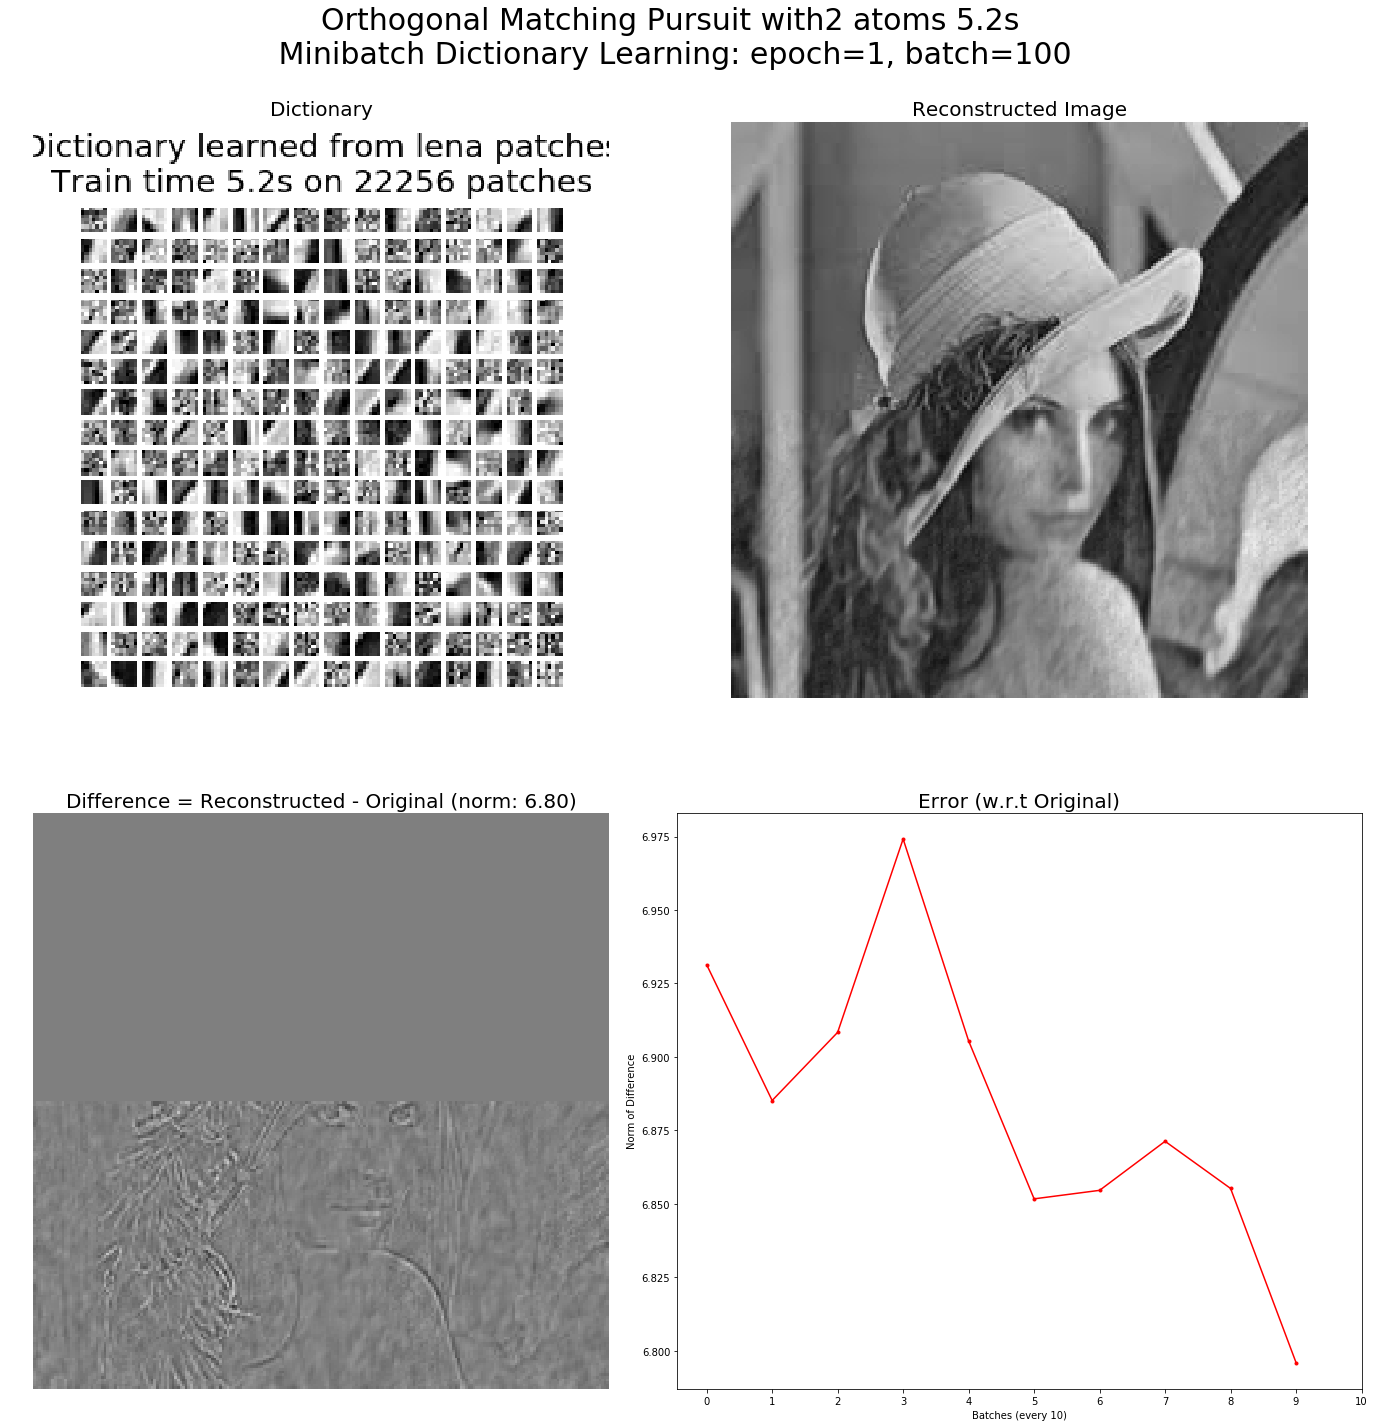

Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=110
error=6.754263127982013
done in 5.51s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=120
error=6.7507329853427605
done in 5.88s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=130
error=6.759413199638875
done in 5.41s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=140
error=6.766832293732715
done in 5.63s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=150
error=6.782864657411773
done in 5.55s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=160
error=6.800253515549207
done in 4.30s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=1, batch=170
error=6.7959110770407785
done in 5.56s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=7
error=6.779732646772544
done in 5.25s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=17
error=6.758616

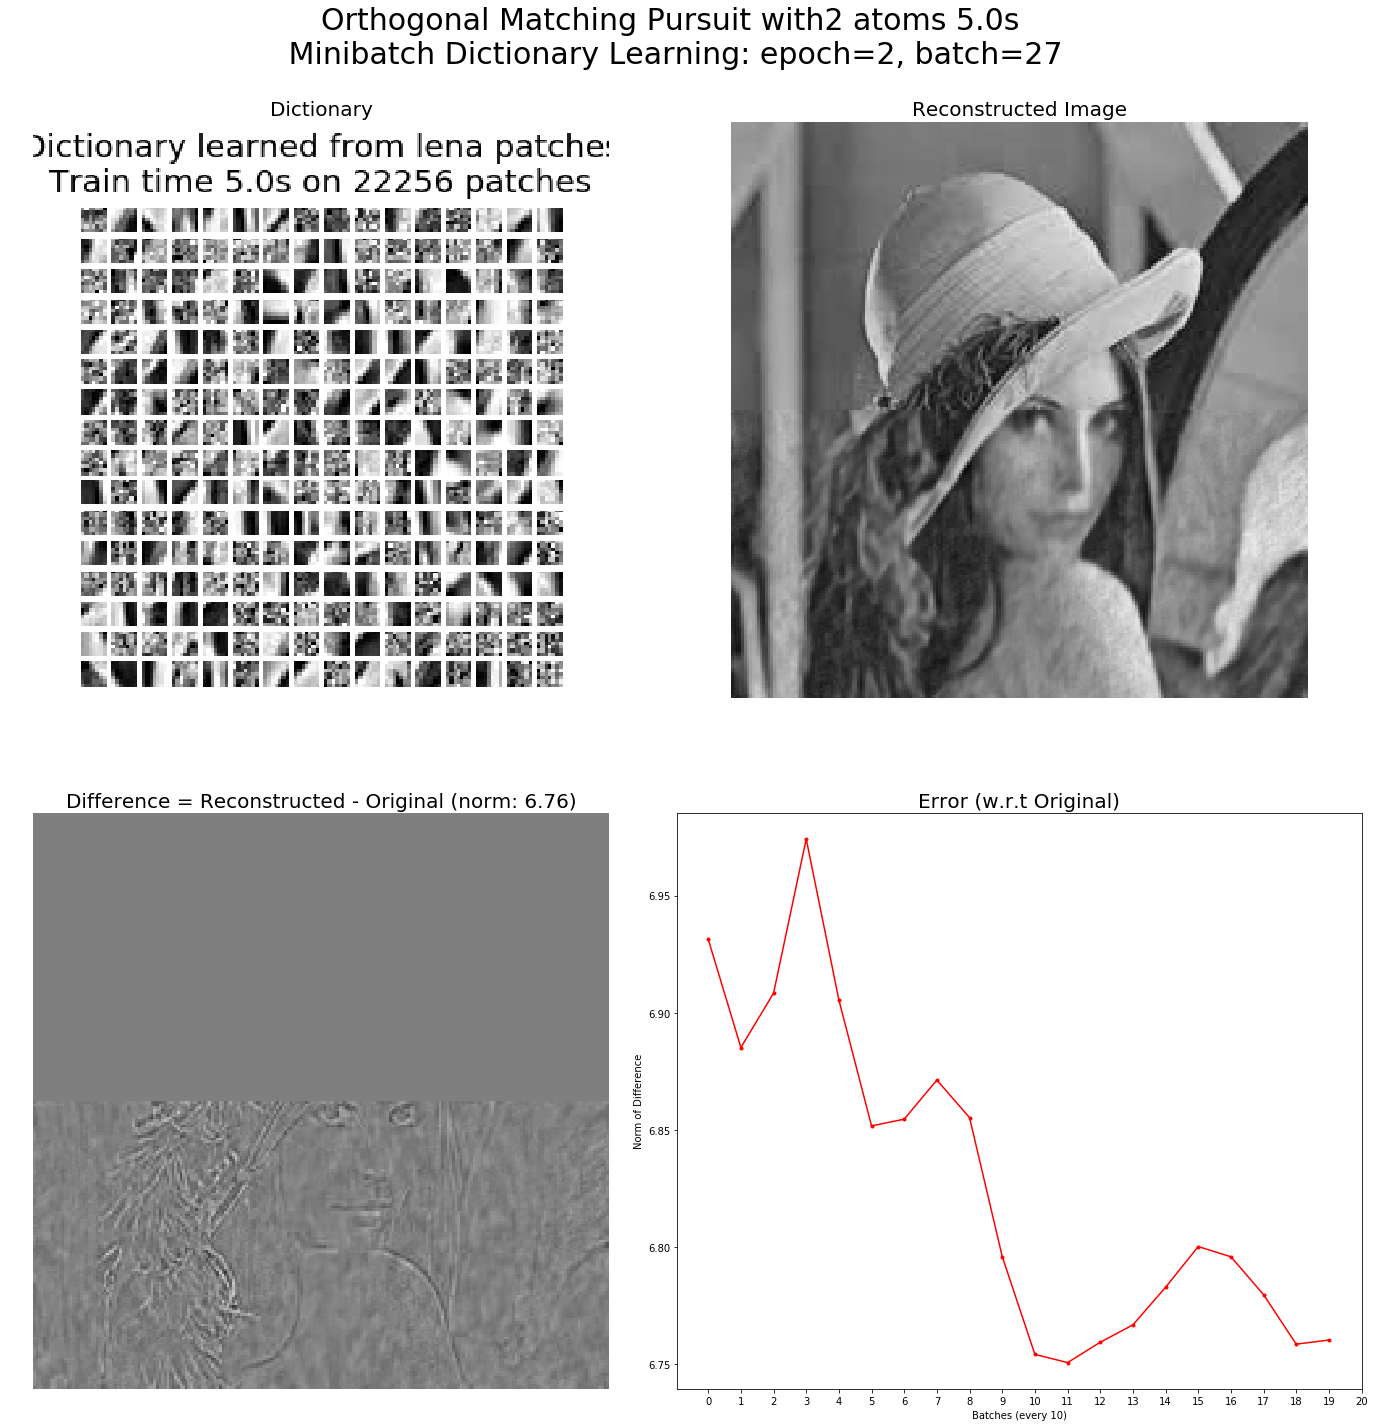

Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=37
error=6.7588877011214405
done in 5.59s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=47
error=6.7542236050899875
done in 5.91s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=57
error=6.742464781115213
done in 6.90s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=67
error=6.732895678605296
done in 5.91s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=77
error=6.741344045894048
done in 5.97s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=87
error=6.748161742005625
done in 5.50s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=97
error=6.74179396100521
done in 5.23s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=107
error=6.7313297475265506
done in 6.29s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=117
error=6.7281181528

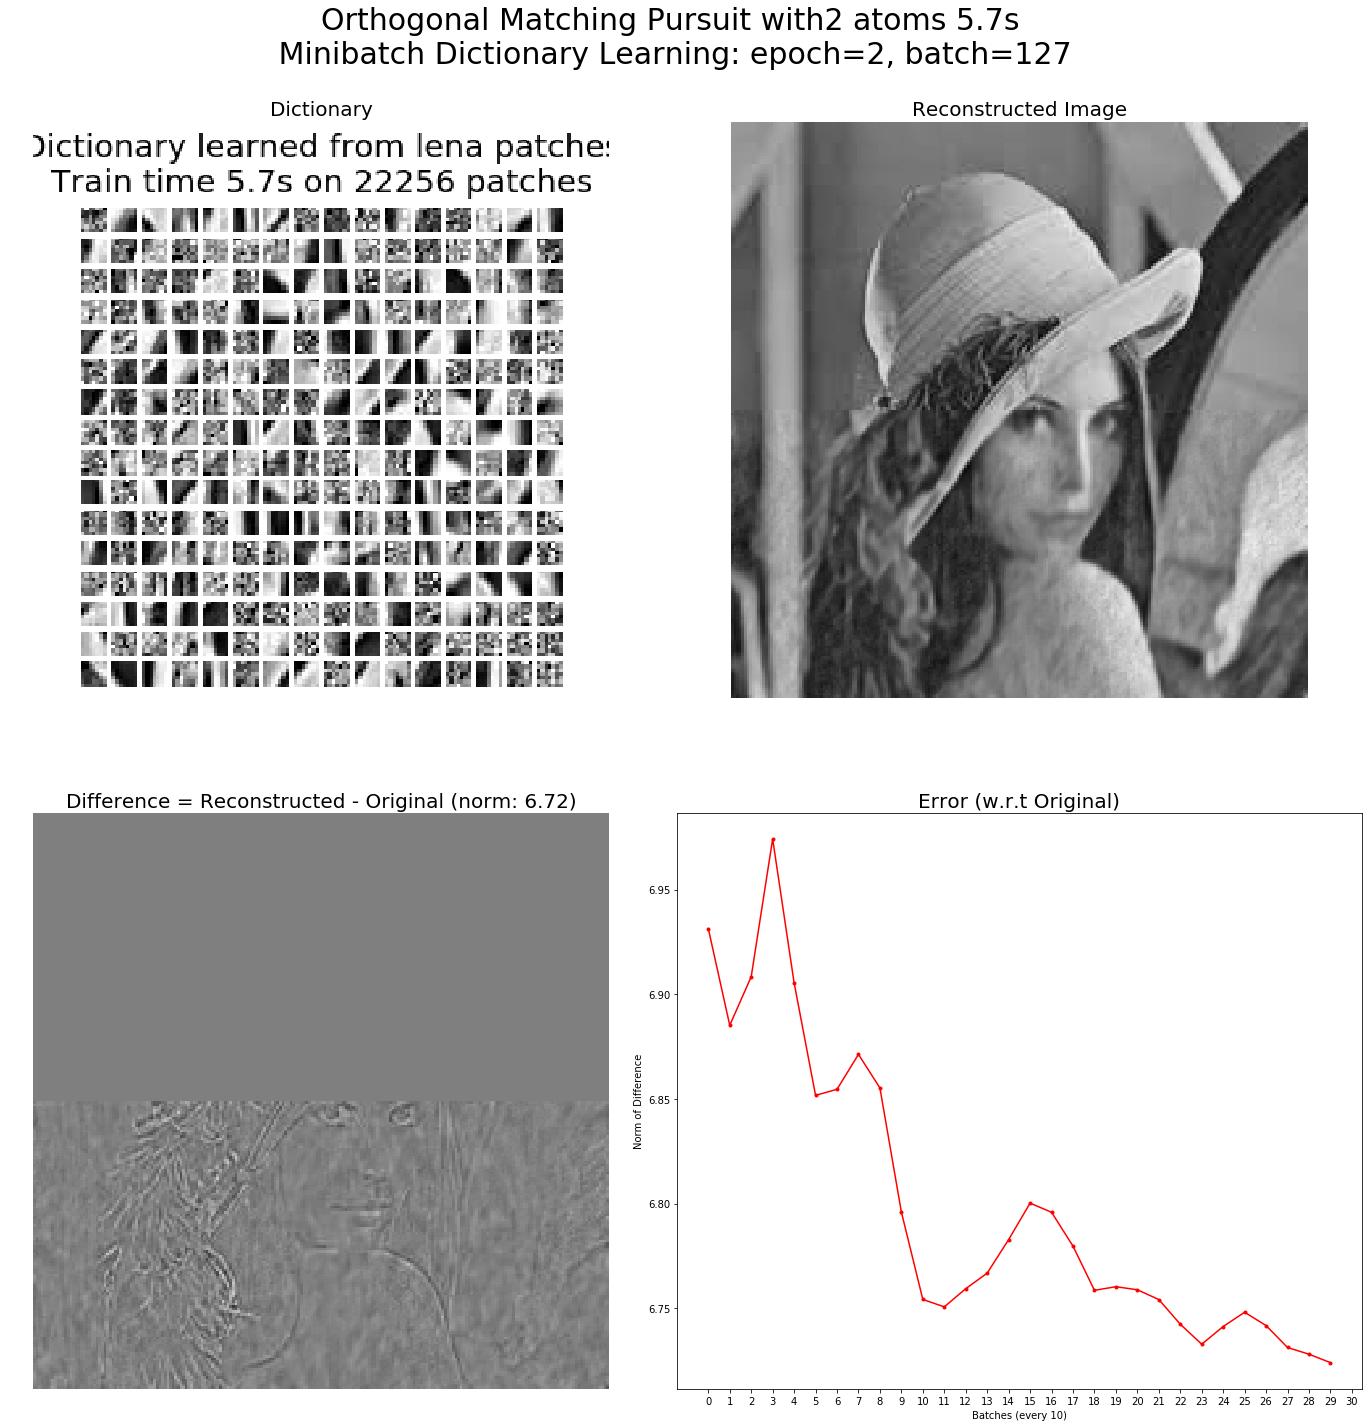

Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=137
error=6.7263188090585695
done in 5.00s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=147
error=6.734595830974991
done in 5.23s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=157
error=6.751513783608852
done in 5.56s.
Orthogonal Matching Pursuit
2 atoms (batch size = 128), epoch=2, batch=167
error=6.762731944875375
done in 5.76s.
done in 8.21s.


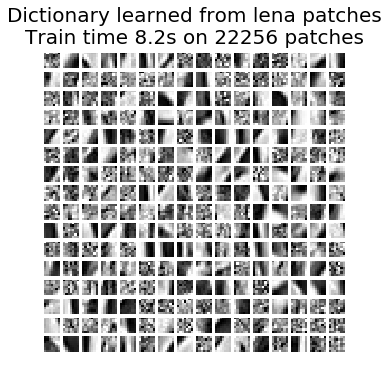

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import numpy as np
import matplotlib.pylab as plt
from time import time

def show_with_diff2(image, reference, V, errors, title, epoch, batch):
    """Helper function to display denoising"""

    difference = image - reference
    
    plt.figure(figsize=(5,5))
    for i, comp in enumerate(V):
        plt.subplot(16, 16, i + 1)
        plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.axis('off')
    plt.suptitle('Dictionary learned from lena patches\n' +
                 'Train time %.1fs on %d patches' % (dt, len(data)),
                 fontsize=20)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.savefig('images/dict_{:d}_{:03d}.png'.format(epoch, batch))
    plt.close()
    
    plt.figure(figsize=(20, 20))
    plt.subplot(221), plt.title('Dictionary', size=20)
    plt.imshow(imread('images/dict_{:d}_{:03d}.png'.format(epoch, batch)), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(222), plt.title('Reconstructed Image', size=20)
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(223)
    plt.title('Difference = Reconstructed - Original (norm: %.2f)' % error, size=20)
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
    
    print(len(errors))
    plt.subplot(224), plt.title('Error (w.r.t Original)', size=20)
    plt.plot(range(len(errors)), errors, 'r.-')
    plt.xlabel('Batches (every 10)')
    plt.ylabel('Norm of Difference')
    plt.xticks(range(len(errors)+1))
    
    plt.suptitle(title, size=30)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.9, 0.02, 0.2)
    plt.savefig('images/out_{:d}_{:03d}.png'.format(epoch, batch))
    plt.show()

lena = rgb2gray(imread('images/lena.png'))
#print(lena.shape, lena.dtype, np.max(lena))
height, width = lena.shape

# Distort the right half of the image
print('Distorting image...')
distorted = lena.copy()
distorted[height // 2:, :] += 0.085 * np.random.randn(height // 2, width)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[height // 2:, :], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
batch_size = 128 #128 #32
n_epochs = 2 #10 # 20
n_batches = len(data) // batch_size
print(n_batches) 

t0 = time()
dico = MiniBatchDictionaryLearning(n_components=256, alpha=1, n_iter=1, batch_size=batch_size)
print('Extracting noisy patches... ')
noisy_data = extract_patches_2d(distorted[height // 2:, :], patch_size)
noisy_data = noisy_data.reshape(noisy_data.shape[0], -1)
intercept = np.mean(noisy_data, axis=0)
noisy_data -= intercept
print('done in %.2fs.' % (time() - t0))

n_updates = 0
errors = []
for epoch in range(n_epochs):
    for i in range(n_batches):
        batch = data[i * batch_size: (i + 1) * batch_size]
        dico.partial_fit(batch)
        V = dico.components_
        n_updates += 1
        if n_updates % 10 == 0:
            print('Orthogonal Matching Pursuit\n2 atoms (batch size = 128), epoch={}, batch={}'.format(epoch+1, i+1))
            kwargs = {'transform_n_nonzero_coefs': 2}
            reconstruction = lena.copy()
            t0 = time()
            dico.set_params(transform_algorithm='omp', **kwargs)
            code = dico.transform(noisy_data)
            patches = np.dot(code, V)
            patches += intercept
            patches = patches.reshape(len(data), *patch_size)
            reconstruction[height // 2:, :] = reconstruct_from_patches_2d(patches, (height // 2, width))
            error = np.sqrt(np.sum((lena - reconstruction) ** 2))
            errors.append(error)
            print('error={}'.format(error))
            dt = time() - t0
            print('done in %.2fs.' % dt)
            if n_updates % 100 == 0:
                show_with_diff2(reconstruction, lena, V, errors,
                   'Orthogonal Matching Pursuit with2 atoms {:.01f}s\n Minibatch Dictionary Learning: epoch={}, batch={}'
                    .format(dt, epoch+1, i+1), epoch+1, i+1)
            
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(5, 5))
for i, comp in enumerate(V):
    plt.subplot(16, 16, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
plt.suptitle('Dictionary learned from lena patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=20)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

### Image Compression with Wavelets

(256, 256)
Fraction of zeros in original image: 0.00311279296875
Fraction of zeros in original image (after division by 8): 0.024658203125
Fraction of zeros in wavelet transform (after division by 8): 0.8888893127441406
(512, 512)


C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\mahotas\convolve.py:480: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nimage[position] = f
C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\mahotas\convolve.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return w[position]


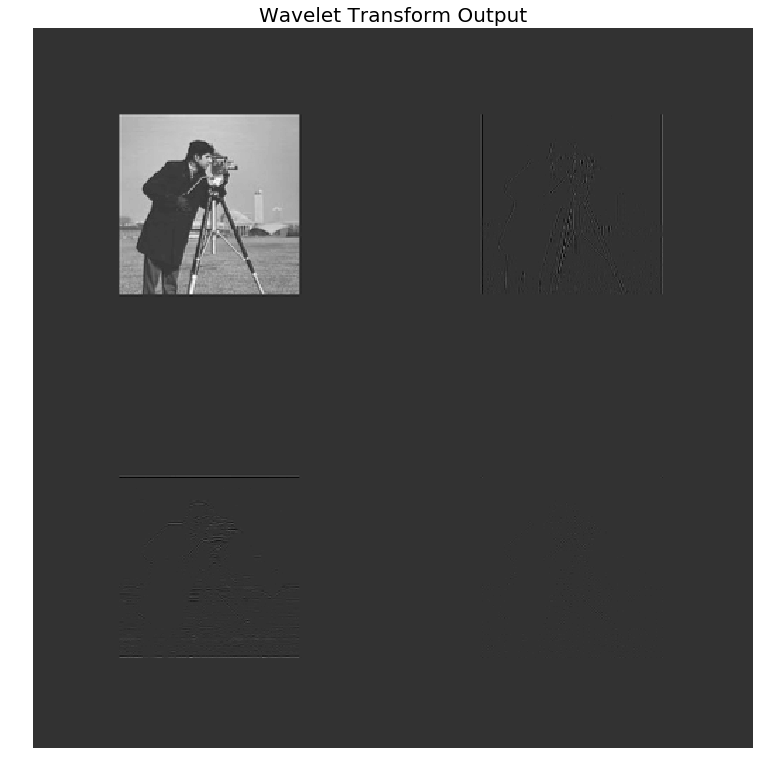

Fraction of zeros in wavelet transform (after division by 8 & soft thresholding): 0.9454841613769531


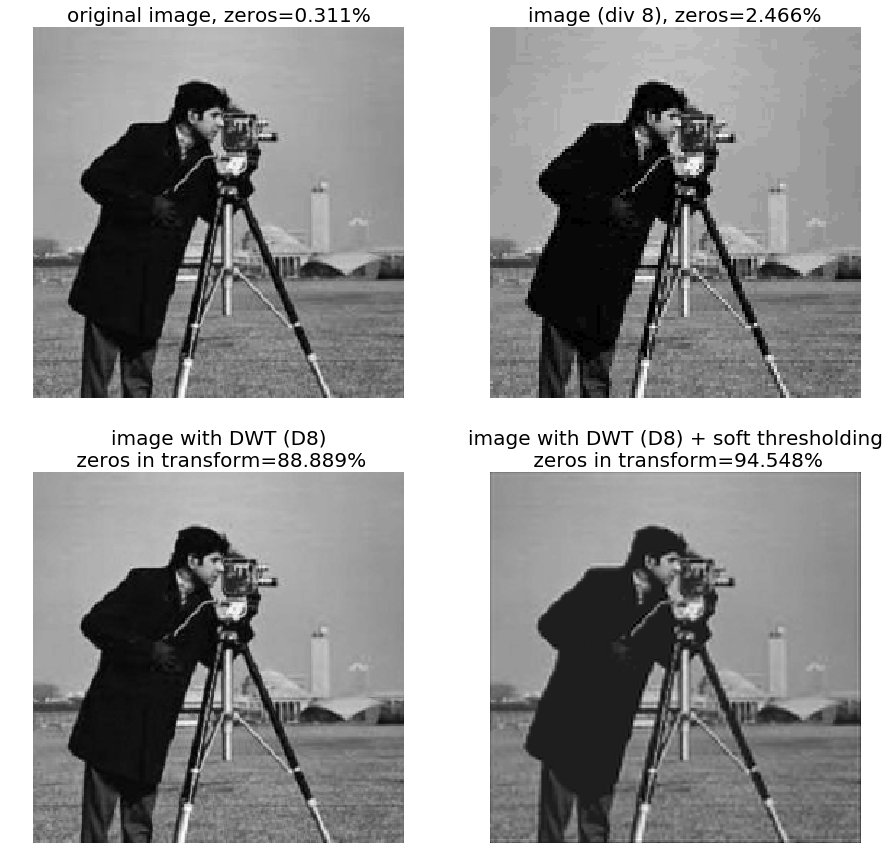

In [ ]:
# https://mahotas.readthedocs.io/en/latest/wavelets.html
import numpy as np
import mahotas
from mahotas.thresholding import soft_threshold
from matplotlib import pyplot as plt
import os

im = mahotas.imread('images/cameraman.png', as_grey=True)
im = im.astype(np.uint8)
print(im.shape)
f = np.mean(im==0)
print("Fraction of zeros in original image: {}".format(f))

im1 = im[::2,::2].copy()
im1 = im1 / 8
im1 = im1.astype(np.uint8)
f1 = np.mean(im1==0)
print("Fraction of zeros in original image (after division by 8): {}".format(f1))

# Transform using D8 Wavelet to obtain transformed image imw
imw = mahotas.daubechies(mahotas.wavelet_center(im),'D8')
# Discard low-order bits:
imw /= 8
imw = imw.astype(np.int8)
mahotas.imsave('images/cameraman_D8.png', (imw - np.min(imw)).astype(np.uint8))
f2 = np.mean(imw==0)
print("Fraction of zeros in wavelet transform (after division by 8): {}".format(f2))
im2 = mahotas.wavelet_decenter(mahotas.idaubechies(imw, 'D8'), im.shape)
im2 = (255 * (im2 - np.min(im2)) / (np.max(im2) - np.min(im2))).astype(np.uint8) # min-max normalization

print(imw.shape)
plt.figure(figsize=(10,10))
plt.imshow(imw), plt.axis('off'), plt.title('Wavelet Transform Output', size=20)
plt.subplots_adjust(0,0,1,1,0.01,0.01)
plt.show()

imw = soft_threshold(imw, 12)
f3 = np.mean(imw==0)
print("Fraction of zeros in wavelet transform (after division by 8 & soft thresholding): {}".format(f3))
#imw = imw.astype(np.int8)
im3 = mahotas.wavelet_decenter(mahotas.idaubechies(imw, 'D8'), im.shape)
im3 = (255 * (im3 - np.min(im3)) / (np.max(im3) - np.min(im3))).astype(np.uint8) # min-max normalization

plt.figure(figsize=(15,15))
plt.gray()
# Show the data:
plt.subplot(221), plt.imshow(im), plt.axis('off')
plt.title('original image, zeros={}%'.format(np.round(100*f, 3)), size=20)
plt.subplot(222), plt.imshow(im1), plt.axis('off')
plt.title('image (div 8), zeros={}%'.format(np.round(100*f1, 3)), size=20)
plt.subplot(223), plt.imshow(im2), plt.axis('off')
plt.title('image with DWT (D8)\n zeros in transform={}%'.format(np.round(100*f2, 3)), size=20)
plt.subplot(224), plt.imshow(im3), plt.axis('off')
plt.title('image with DWT (D8) + soft thresholding\n zeros in transform={}%'.format(np.round(100*f3, 3)), size=20)
plt.show()